<a href="https://colab.research.google.com/github/Poorya0071/Image-classification/blob/main/Food101_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Food 101
In this notebook, we are going to predict the type of food by using 101 food classification dataset in tensorflow.

In [2]:
# check GPU is on.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c24ca25c-3993-33c8-1caf-0fea5ace3b40)


In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__)

2.9.2


In [6]:
import tensorflow_datasets.public_api as tfds

Let's upload the dataset, we use the name to find the food101 from the list of the tf datasets, split for splitting to train and test by default by TensorFlow, shuffle_files to shuffle data, and as_supervised to have images and labels in tuple format.

In [8]:
dataset_list = tfds.list_builders()

In [10]:
(train_data, test_data), ds_info = tfds.load(name='food101', split = ['train', 'validation'],
                                             shuffle_files= True, as_supervised= True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteWMX5HN/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteWMX5HN/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [11]:
len(train_data)

75750

In [18]:
ds_info.description

"This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels."

In [19]:
ds_info.data_dir

'~/tensorflow_datasets/food101/2.0.0'

In [23]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

Assign class names and check their length.

In [29]:
clas_names = ds_info.features['label'].names
len(clas_names)

101

Let's get one sample and extract the shape and type of images, then define a preprocessing function to resize all images and change the type to float 32 as tf is float 32 types friendly.

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {clas_names[label.numpy()]}
        """)

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [52]:
def preprocess_function(image, label, shape=224):
  image = tf.image.resize(image,[shape,shape])
  return tf.cast(image, tf.float32)/255, label

As the maximum size of images's pixel is 255, we divided all to 255 for scaling from 0 to 1.

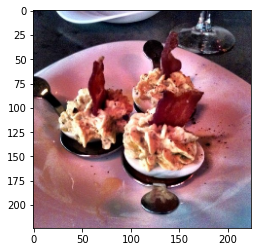

In [53]:
plt.imshow(preprocess_function(image, label)[0])

In [55]:
preprocess_function(image, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.08549421, 0.09725891, 0.17176871],
         [0.06962784, 0.07747098, 0.15982394],
         [0.06340537, 0.07124851, 0.16144459],
         ...,
         [0.1475189 , 0.18365328, 0.2978992 ],
         [0.11848745, 0.1616247 , 0.2824331 ],
         [0.1026002 , 0.1443369 , 0.27402875]],
 
        [[0.08663466, 0.09055623, 0.1689876 ],
         [0.04303721, 0.04695878, 0.12539016],
         [0.06318527, 0.06710684, 0.14945978],
         ...,
         [0.17839168, 0.2254505 , 0.3184479 ],
         [0.16632594, 0.21310467, 0.3156657 ],
         [0.13157374, 0.17835245, 0.28143367]],
 
        [[0.12382953, 0.11990796, 0.18881553],
         [0.08235294, 0.07843138, 0.1490196 ],
         [0.12426972, 0.11708684, 0.197459  ],
         ...,
         [0.14459799, 0.20558235, 0.2754105 ],
         [0.16678679, 0.22729099, 0.29927978],
         [0.17823154, 0.23873574, 0.31072453]],
 
        ...,
 
        [[0.59831953, 0.39047647

let's map training data to the preprocessing function that we built.

In [56]:
train_data = train_data.map(map_func= preprocess_function, num_parallel_calls= tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map( preprocess_function, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

use mixed precision to increase the speed of the process.

In [61]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [62]:
mixed_precision.global_policy()

<Policy "mixed_float16">

implement a simple conv2d model to see the results.

In [70]:
model_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation = 'relu', input_shape = (224,224,3)),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation= 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(101, activation = 'softmax')

])

model_0.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [71]:

model_0_history = model_0.fit(train_data, steps_per_epoch=len(train_data), epochs = 10, validation_data = test_data, validation_steps = int(0.2 * len(test_data)))

Epoch 1/10
2368/2368 [==============================] - 193s 77ms/step - loss: 4.5601 - accuracy: 0.0196 - val_loss: 4.4593 - val_accuracy: 0.0390
Epoch 2/10
2368/2368 [==============================] - 183s 77ms/step - loss: 4.2120 - accuracy: 0.0830 - val_loss: 4.5266 - val_accuracy: 0.0564
Epoch 3/10
2368/2368 [==============================] - 183s 76ms/step - loss: 2.9212 - accuracy: 0.3256 - val_loss: 5.8041 - val_accuracy: 0.0489
Epoch 4/10
2368/2368 [==============================] - 185s 77ms/step - loss: 1.3234 - accuracy: 0.6806 - val_loss: 9.3662 - val_accuracy: 0.0512
Epoch 5/10
2368/2368 [==============================] - 183s 76ms/step - loss: 0.5344 - accuracy: 0.8712 - val_loss: 15.0134 - val_accuracy: 0.0443
Epoch 6/10
2368/2368 [==============================] - 183s 77ms/step - loss: 0.2409 - accuracy: 0.9423 - val_loss: 20.1460 - val_accuracy: 0.0429
Epoch 7/10
2368/2368 [==============================] - 186s 78ms/step - loss: 0.1444 - accuracy: 0.9664 - val_loss:

Results are awful as training accuracy is great, but val accuracy is very low. In conclusion, the model is overfitted.

Let's try EfficientB0 from tensorflow hub.

In [81]:
import tensorflow_hub as hub

keras_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", input_shape=(224,224,3), dtype = tf.float32)

model_tl = tf.keras.Sequential([
                                keras_layer,
                                tf.keras.layers.Dense(101, activation='softmax', name='output_layer')
                                ])

#  model = tf.keras.Sequential([
#     feature_extractor_layer, # use the feature extraction layer as the base
#     layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
#   ])

model_tl.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_tl.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,945
Trainable params: 129,381
Non-trainable params: 4,049,564
_________________________________________________________________


In [82]:
model_tl_history = model_tl.fit(train_data, steps_per_epoch=len(train_data), epochs = 10, validation_data = test_data, validation_steps = int(0.2 * len(test_data)))

Epoch 1/10
2368/2368 [==============================] - 197s 79ms/step - loss: 1.7196 - accuracy: 0.5824 - val_loss: 1.1479 - val_accuracy: 0.6996
Epoch 2/10
2368/2368 [==============================] - 187s 78ms/step - loss: 1.2000 - accuracy: 0.6885 - val_loss: 1.0495 - val_accuracy: 0.7152
Epoch 3/10
2368/2368 [==============================] - 204s 86ms/step - loss: 1.0547 - accuracy: 0.7237 - val_loss: 1.0135 - val_accuracy: 0.7223
Epoch 4/10
2368/2368 [==============================] - 216s 91ms/step - loss: 0.9590 - accuracy: 0.7477 - val_loss: 0.9961 - val_accuracy: 0.7265
Epoch 5/10
2368/2368 [==============================] - 194s 81ms/step - loss: 0.8891 - accuracy: 0.7655 - val_loss: 1.0008 - val_accuracy: 0.7253
Epoch 6/10
2368/2368 [==============================] - 187s 78ms/step - loss: 0.8332 - accuracy: 0.7793 - val_loss: 0.9861 - val_accuracy: 0.7308
Epoch 7/10
2368/2368 [==============================] - 219s 92ms/step - loss: 0.7869 - accuracy: 0.7907 - val_loss: 0

This model works good, $val_{acc} ≈ 73 \%$ ,we can tune hyperparameters and also use other models from TensorFlow Hub to increase the validation accuracy.

In [83]:
model_tl.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.0020 - accuracy: 0.7291


[1.002023696899414, 0.7291485071182251]

Let's see the plot for loss and acc of two models.
model_0 clearly does not work well, but model_tl works well.

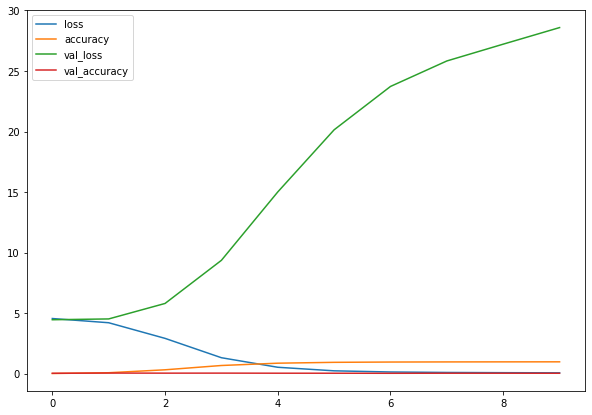

In [86]:
import pandas as pd
pd.DataFrame(model_0_history.history).plot(figsize=(10, 7));

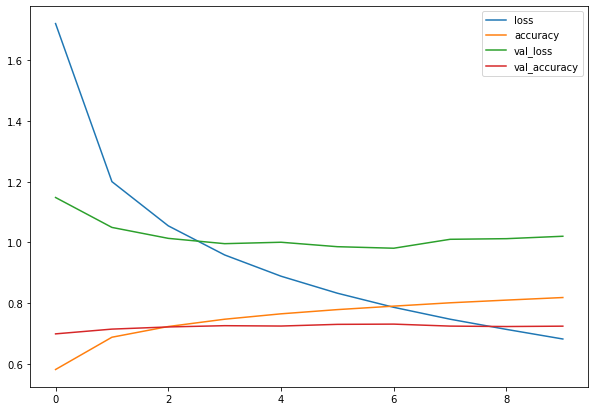

In [87]:
pd.DataFrame(model_tl_history.history).plot(figsize=(10, 7));